In [2]:
import pandas as pd
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
df = pd.read_csv('Wimbledon_featured_matches.csv')
df.loc[(df.p1_score=='AD'),'p1_score'] = 50
df.loc[(df.p2_score=='AD'),'p2_score'] = 50
df['p1_score'] = df['p1_score'].astype(int)
df['p2_score'] = df['p2_score'].astype(int)

# df.loc[(df.speed_mph=='NA'),'speed_mph'] = 0

# df.dropna(subset=['speed_mph'],inplace=True)
df['speed_mph'].fillna(0, inplace=True)

In [3]:
x1_ls,x2_ls,x3_ls,x4_ls,x5_ls,x6_ls,x7_ls,x8_ls,x9_ls,x10_ls,x11_ls,\
x12_ls,x13_ls,x14_ls,x15_ls,x16_ls=[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
label_ls = []
for match_id,set_no,game_no,point_no in zip(df.match_id,df.set_no,df.game_no,df.point_no):
    match = df[df.match_id==match_id]
    set_ = match[match.set_no==set_no]
    game_ = set_[set_.game_no==game_no]
    point_ = game_[game_.point_no==point_no]
    x1 = point_['p1_games'].values[0]
    x2 = point_['p1_score'].values[0] - point_['p2_score'].values[0]
    x3 = 1 if point_['serve_no'].values[0] == 1 else 0
    x4 = 0 if x2<0 else 1
    x5 = point_['p1_sets'].values[0] - point_['p2_sets'].values[0]
    x6 = 1 if 1 in game_['p1_ace'].values else 0    # 是否打出ACE球
    x7 = 1 if 1 in game_['p1_winner'].values else 0 # 是否打出对手无法触及的球（程度低于ACE球）
    x8 = 1 if 1 in game_['p1_double_fault'].values else 0   # 是否出现双误
    x9 = 1 if 1 in game_['p1_unf_err'].values else 0    # 是否出现非受迫性失误
    x10 = game_['p1_net_pt_won'].sum()/game_['p1_net_pt'].sum() if game_['p1_net_pt'].sum()!= 0 else 0  #网前进攻得分比例
    x11 = set_['p1_break_pt_won'].sum()/set_['p1_break_pt'].sum() if game_['p1_break_pt'].sum()!= 0 else 0  #破发点得分比例

    index = match.index.tolist().index(point_.index.tolist()[0])    # 索引从0开始
    x12 = match.iloc[:index+1]['p1_distance_run'].sum()
    x13 = match.iloc[index-2:index+1]['p1_distance_run'].sum()
    x14 = point_['p1_distance_run'].values[0]   # 本局跑动距离
    x15 = point_['speed_mph'].values[0]
    x16 = x15*x3
    
    label = 1 if point_['point_victor'].values[0] == 1 else 0
    label_ls.append(label)
    x1_ls.append(x1)
    x2_ls.append(x2)
    x3_ls.append(x3)
    x4_ls.append(x4)
    x5_ls.append(x5)
    x6_ls.append(x6)
    x7_ls.append(x7)
    x8_ls.append(x8)
    x9_ls.append(x9)
    x10_ls.append(x10)
    x11_ls.append(x11)
    x12_ls.append(x12)
    x13_ls.append(x13)
    x14_ls.append(x14)
    x15_ls.append(x15)
    x16_ls.append(x16)
    

In [4]:
dataset = pd.DataFrame({'x2':x2_ls,'x4':x4_ls,'x5':x5_ls,'x6':x6_ls,'x7':x7_ls,'x8':x8_ls,'x9':x9_ls,'x10':x10_ls,'x11':x11_ls,'label':label_ls})
dataset

,x2,x4,x5,x6,x7,x8,x9,x10,x11,label
0,0,1,0,1,1,0,1,1.0,0.0,0
1,-15,0,0,1,1,0,1,1.0,0.0,1
2,0,1,0,1,1,0,1,1.0,0.0,0
3,-15,0,0,1,1,0,1,1.0,0.0,1
4,0,1,0,1,1,0,1,1.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...
6935,-15,0,0,0,1,0,1,1.0,0.0,1
6936,0,1,0,0,1,0,1,1.0,0.0,1
6937,15,1,0,0,1,0,1,1.0,0.0,0
6938,0,1,0,0,1,0,1,1.0,0.0,1


In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
columns = dataset.columns[:-1]
scaler.fit(dataset[columns].values)
dataset[columns] = scaler.transform(dataset[columns].values)

In [10]:
import warnings
warnings.filterwarnings("ignore")

def function(model):
    # 借助各种评价指标使用5折交叉验证
    auc = round(cross_val_score(model,dataset[columns].values,dataset['label'].values, cv=5,scoring='roc_auc').mean(),2)
    acc = round(cross_val_score(model,dataset[columns].values,dataset['label'].values, cv=5,scoring='accuracy').mean(),2)
    recall = round(cross_val_score(model,dataset[columns].values,dataset['label'].values, cv=5,scoring='recall').mean(),2)
    precision = round(cross_val_score(model,dataset[columns].values,dataset['label'].values, cv=5,scoring='precision').mean(),2)
    f1 = round(cross_val_score(model,dataset[columns].values,dataset['label'].values, cv=5,scoring='f1').mean(),2)
    return acc,recall,precision,f1,auc

model = LGBMClassifier(random_state=30,force_col_wise=True)
print(f'LGBMClassifier acc,recall,precision,f1,auc :{function(model)}')
model = XGBClassifier(random_state=50)
print(f'XGBClassifier acc,recall,precision,f1,auc :{function(model)}')
model = SVC(random_state=50)
print(f'SVC acc,recall,precision,f1,auc :{function(model)}')
model = MLPClassifier(random_state=60)
print(f'MLPClassifier acc,recall,precision,f1,auc :{function(model)}')
model = LogisticRegression(random_state=50)
print(f'LogisticRegression acc,recall,precision,f1,auc :{function(model)}')

# 试图使用随机森林，梯度提升树等模型
from sklearn import model_selection
from sklearn import tree
clf=tree.DecisionTreeClassifier()
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=42)
print(f'clf acc,recall,precision,f1,auc :{function(clf)}')
print(f'rf acc,recall,precision,f1,auc :{function(rf)}')
print(f'gb acc,recall,precision,f1,auc :{function(gb)}')

# 试图使用回归树，效果不佳
# from sklearn.tree import DecisionTreeRegressor
# regressor = DecisionTreeRegressor(random_state=42)
# print(f'regressor acc,recall,precision,f1,auc :{function(regressor)}')

[LightGBM] [Info] Number of positive: 2840, number of negative: 2712
[LightGBM] [Info] Total Bins 47
[LightGBM] [Info] Number of data points in the train set: 5552, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511527 -> initscore=0.046118
[LightGBM] [Info] Start training from score 0.046118
[LightGBM] [Info] Number of positive: 2839, number of negative: 2713
[LightGBM] [Info] Total Bins 48
[LightGBM] [Info] Number of data points in the train set: 5552, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511347 -> initscore=0.045397
[LightGBM] [Info] Start training from score 0.045397
[LightGBM] [Info] Number of positive: 2839, number of negative: 2713
[LightGBM] [Info] Total Bins 49
[LightGBM] [Info] Number of data points in the train set: 5552, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511347 -> initscore=0.045397
[LightGBM] [Info] Start training from score 0.045397
[LightGBM] [Info] Number of 

[LightGBM] [Info] Number of positive: 2820, number of negative: 2732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000540 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 49
[LightGBM] [Info] Number of data points in the train set: 5552, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507925 -> initscore=0.031703
[LightGBM] [Info] Start training from score 0.031703
[0.24780729 0.7011725  0.24630738 ... 0.80765125 0.57996183 0.80230409]
[0.13414039 0.6804158  0.23735726 ... 0.8064092  0.5694961  0.8433282 ]
[0.28924499 0.6831402  0.2962686  ... 0.6879648  0.68642068 0.67259324]
[0.31362636 0.64470253 0.27349374 ... 0.84453665 0.63257238 0.65423597]
[0.43785826 0.7756593  0.27224317 ... 0.72963637 0.58095532 0.53540156]
[0.01533333 0.64749544 0.2203159  ... 0.79437817 0.53682287 0.7882381 ]
[0.4409486  0.7612

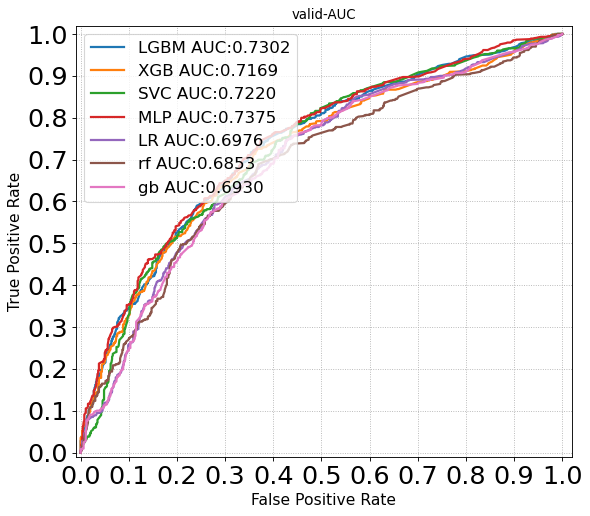

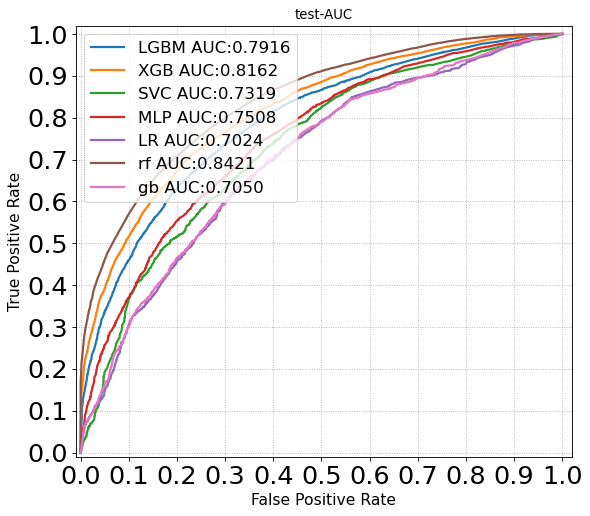

In [11]:
import numpy as np
from sklearn import metrics
def f(model_list,name_list,types='train'):
    plt.figure(figsize=(8, 7), dpi=80, facecolor='w')    # dpi:每英寸长度的像素点数；facecolor 背景颜色
    plt.xlim((-0.01, 1.02))  # x,y 轴刻度的范围
    plt.ylim((-0.01, 1.02))
    plt.xticks(np.arange(0, 1.1, 0.1))  #绘制刻度
    plt.yticks(np.arange(0, 1.1, 0.1))

    if types == 'test':
        for model,name in zip(model_list,name_list):
            # 取列别1的概率值
            ytest_prob = model.predict_proba(xvalid)[:,1]
            print(ytest_prob)
            fpr, tpr, _ = metrics.roc_curve(yvalid, ytest_prob)
            auc = metrics.auc(fpr, tpr)
            plt.plot(fpr, tpr, '-', lw=2, label=f'{name} AUC:%.4f' % auc)  # 绘制AUC 曲线
            plt.title("valid-AUC")
    else:
        for model,name in zip(model_list,name_list):
            # 取列别1的概率值
            ytest_prob = model.predict_proba(xtrain)[:,1]
            fpr, tpr, _ = metrics.roc_curve(ytrain, ytest_prob)
            auc = metrics.auc(fpr, tpr)
            plt.plot(fpr, tpr, '-', lw=2, label=f'{name} AUC:%.4f' % auc)  # 绘制AUC 曲线
            plt.title("test-AUC")
    plt.legend(loc='upper left',fontsize=15)    # 设置显示标签的位置
    plt.xlabel('False Positive Rate', fontsize=14)   #绘制x,y 坐标轴对应的标签
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.tick_params(labelsize=23)

    plt.grid(True, ls=':')  # 绘制网格作为底板;b是否显示网格线；ls表示line style
    # plt.savefig(f'问题1\\roc_auc({types}(采样前)).png',dpi=500)
    plt.show()
    
xtrain, xvalid, ytrain, yvalid = train_test_split(dataset[columns].values,dataset['label'].values,random_state=620,test_size=0.2)

model1 = LGBMClassifier(random_state=30)
model2 = XGBClassifier(random_state=50)
model3 = SVC(probability=True,random_state=50)
model4 = MLPClassifier(random_state=60)
model5 = LogisticRegression(random_state=50)
model7 = RandomForestClassifier(n_estimators=100, random_state=42)
model8 = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=42)

model1.fit(xtrain,ytrain)
model2.fit(xtrain,ytrain)
model3.fit(xtrain,ytrain)
model4.fit(xtrain,ytrain)
model5.fit(xtrain,ytrain)

model7.fit(xtrain,ytrain)
model8.fit(xtrain,ytrain)

f([model1,model2,model3,model4,model5,model7,model8],['LGBM','XGB','SVC','MLP','LR','rf','gb'],'test')
f([model1,model2,model3,model4,model5,model7,model8],['LGBM','XGB','SVC','MLP','LR','rf','gb'],'train')